#Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import quantile_transform
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset,DataLoader

#Data Exploration

In [ ]:
df = pd.read_csv('Sensors.csv')
df.drop(df.tail(1).index,inplace=True) #remove the last row
df['All_Furnace'] = df[['Furnace 1 [kW]','Furnace 2 [kW]']].sum(axis=1)
df['All_Kitchen'] = df[['Kitchen 12 [kW]','Kitchen 14 [kW]','Kitchen 38 [kW]']].mean(axis=1)
df = df.drop(['icon', 'summary', 'cloudCover','time','Kitchen 12 [kW]', 'Kitchen 14 [kW]', 'Kitchen 38 [kW]', 'Furnace 1 [kW]', 'Furnace 2 [kW]'], axis=1)
time_index = pd.date_range('2016-01-01 05:00', periods=len(df), freq='min')  
time_index = pd.DatetimeIndex(time_index)
df = df.set_index(time_index)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df.head()

,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW],temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability,All_Furnace,All_Kitchen
2016-01-01 05:00:00,0.932833,0.003483,0.932833,0.000033,0.442633,0.124150,0.006983,0.013083,0.031350,0.001017,0.004067,0.001517,0.003483,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,0.082617,0.000189
2016-01-01 05:01:00,0.934333,0.003467,0.934333,0.000000,0.444067,0.124000,0.006983,0.013117,0.031500,0.001017,0.004067,0.001650,0.003467,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,0.084533,0.000189
2016-01-01 05:02:00,0.931817,0.003467,0.931817,0.000017,0.446067,0.123533,0.006983,0.013083,0.031517,0.001000,0.004067,0.001650,0.003467,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,0.083017,0.000206
2016-01-01 05:03:00,1.022050,0.003483,1.022050,0.000017,0.446583,0.123133,0.006983,0.013000,0.031500,0.001017,0.004067,0.001617,0.003483,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,0.175417,0.000217
2016-01-01 05:04:00,1.139400,0.003467,1.139400,0.000133,0.446533,0.122850,0.006850,0.012783,0.031500,0.001017,0.004067,0.001583,0.003467,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,0.300917,0.000261


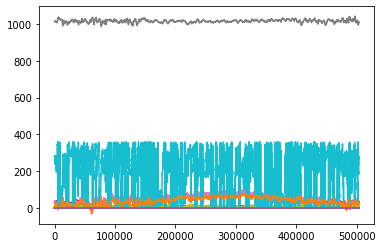

In [ ]:
#Approach 1: use each appliance's historical values to predict the next time step value (this notebook's focus)
#Approach 2: use weather/humidity and other features as input, and each appliance's power consumption as targets
training_set = df.iloc[:,:].values
plt.plot(training_set)
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503910 entries, 2016-01-01 05:00:00 to 2016-12-16 03:29:00
Freq: T
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   use [kW]             503910 non-null  float64
 1   gen [kW]             503910 non-null  float64
 2   House overall [kW]   503910 non-null  float64
 3   Dishwasher [kW]      503910 non-null  float64
 4   Home office [kW]     503910 non-null  float64
 5   Fridge [kW]          503910 non-null  float64
 6   Wine cellar [kW]     503910 non-null  float64
 7   Garage door [kW]     503910 non-null  float64
 8   Barn [kW]            503910 non-null  float64
 9   Well [kW]            503910 non-null  float64
 10  Microwave [kW]       503910 non-null  float64
 11  Living room [kW]     503910 non-null  float64
 12  Solar [kW]           503910 non-null  float64
 13  temperature          503910 non-null  float64
 14  humidity             50391

In [ ]:
import plotly.graph_objs as go
from plotly.offline import iplot

def plot_dataset(df, title):
    data = []
    value = go.Scatter(
        x=df.index,
        y=df.value,
        mode="lines",
        name="values",
        marker=dict(),
        text=df.index,
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)

    layout = dict(
        title=title,
        xaxis=dict(title="Date", ticklen=5, zeroline=False),
        yaxis=dict(title="Value", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)

In [ ]:
df = df.rename(columns={'use [kW]': 'value'})
plot_dataset(df, title = 'Energy Consumption at a New York Household' )

#Data Preprocessing

In [ ]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 7
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [ ]:
trainX.shape

torch.Size([337614, 7, 25])

In [ ]:
trainY.shape

torch.Size([337614, 25])

#Models

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

#Training

In [ ]:
num_epochs = 1000
learning_rate = 0.01

input_size = 25
hidden_size = 8
num_layers = 1

num_classes = 25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
loss_ = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss.backward()
    loss_.append(loss)
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.21333
Epoch: 100, loss: 0.01417
Epoch: 200, loss: 0.00686
Epoch: 300, loss: 0.00471
Epoch: 400, loss: 0.00418
Epoch: 500, loss: 0.00395
Epoch: 600, loss: 0.00382
Epoch: 700, loss: 0.00373
Epoch: 800, loss: 0.00367
Epoch: 900, loss: 0.00362


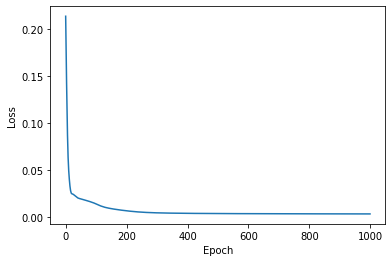

In [ ]:
plt.plot(loss_)
plt.xlabel('Epoch')
plt.ylabel('Loss')
# Save the trained model
PATH = './lstm_withWeather.pth'
torch.save(lstm.state_dict(), PATH)

#Testing

In [ ]:
input_size = 18
hidden_size = 8
num_layers = 1

num_classes = 18

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
PATH_lstm = './lstm_EnergyPre.pth'
lstm.load_state_dict(torch.load(PATH_lstm))

In [ ]:
lstm.eval()
test_predict = lstm(testX)
data_predict = test_predict.data.numpy()
dataY_plot = testY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(testY)

from sklearn.metrics import mean_squared_error
MAE = np.mean(np.abs([data_predict[j]-dataY_plot[j] for j in range(len(data_predict))]))
RMSE = np.sqrt(mean_squared_error(data_predict,dataY_plot))
MSE = mean_squared_error(data_predict,dataY_plot) 
print('MAE is', MAE, 'MSE is', MSE, 'RMSE is', RMSE)

MAE is 0.7329598957431883 MSE is 9.386465332725113 RMSE is 3.06373388738727


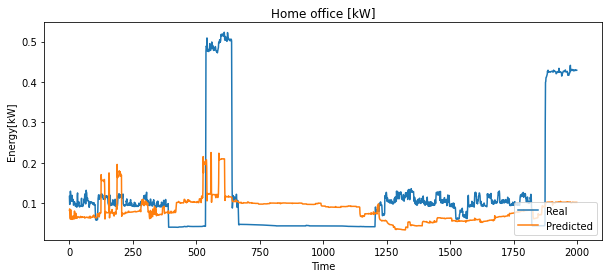

In [ ]:
feature = 4
f = plt.figure(figsize=(10,4))
plt.plot(dataY_plot[0:2000,feature])
plt.plot(data_predict[0:2000,feature])
plt.title(df.columns[feature])
plt.xlabel('Time')
plt.ylabel('Energy[kW]')
plt.legend(['Real','Predicted'],loc = 'lower right')
plt.show()

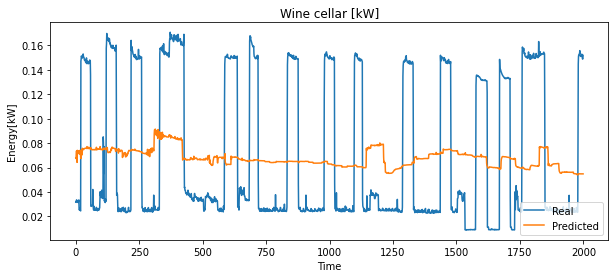

In [ ]:
feature = 6
f = plt.figure(figsize=(10,4))
plt.plot(dataY_plot[0:2000,feature])
plt.plot(data_predict[0:2000,feature])
plt.title(df.columns[feature])
plt.xlabel('Time')
plt.ylabel('Energy[kW]')
plt.legend(['Real','Predicted'],loc = 'lower right')
plt.show()